In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Data Generation
===

In [2]:
np.random.seed(10)
p, q = (np.random.rand(i, 2) for i in (4, 5))
p_big, q_big = (np.random.rand(i, 80) for i in (100, 120))

print(p, "\n\n", q)

[[0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]] 

 [[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]]


Solution
===

In [7]:
def naive(p, q):
  n, m = p.shape[0], q.shape[0]
  d = np.zeros((n, m))
  for i in range(n):
    for j in range(m):
      d[i][j] = np.sqrt(np.sum((p[i] - q[j])**2))
  return d
  
naive_result = naive(p, q)
def compare_with_naive(a):
  if np.allclose(a, naive_result):
    print('Equal to naive.')
  else:
    print('Different from naive!')

compare_with_naive(naive(p, q)) # sanity check

Equal to naive.


### Use matching indices

Instead of iterating through indices, one can use them directly to parallelize the operations with Numpy.

In [8]:
rows, cols = np.indices((p.shape[0], q.shape[0]))
print(rows, end='\n\n')
print(cols)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


In [9]:
print(p[rows.ravel()], end='\n\n')
print(q[cols.ravel()])

[[0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]
 [0.19806286 0.76053071]]

[[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]
 [0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607

In [11]:
def with_indices(p, q):
  n, m = p.shape[0], q.shape[0]
  rows, cols = np.indices((n, m))
  flat = np.sqrt(np.sum((p[rows.ravel()] - q[cols.ravel()])**2, axis=1))
  return flat.reshape(n, m)
  
compare_with_naive(with_indices(p, q))

Equal to naive.


### Use a library

`scipy` is the equivalent of matlab toolboxes and have a lot to offer. Actually the pairwise computation is part of the library through the `spatial` module.

In [12]:
from scipy.spatial.distance import cdist

def scipy_version(p, q):
    return cdist(p, q)

### Numpy Magic

In [13]:
def tensor_broadcasting(p, q):
    return np.sqrt(np.sum((p[:,np.newaxis,:]-q[np.newaxis,:,:])**2, axis=2))

### Numpy Magic without Extra Memory Usage

The above broadcasting trick uses memory linear in D, which is fine since D=2, but is not scalable. The below does not. This one I remember from Stanford's CS231N! It also beats the other methods, probably due to @ being multicore.

In [14]:
def cs231_style(p, q):
  # Remember (p - q)^2 = p^2 + q^2 - 2 * p * q
  # For proper broadcasting: target (N, M)
  return np.sqrt(np.sum(p**2, axis=1)[:, np.newaxis] + np.sum(q**2, axis=1) - 2 * (p @ q.T))

# Compare methods

In [21]:
methods = [naive, with_indices, scipy_version, tensor_broadcasting, cs231_style]

# first, correctness
naive_result = naive(p_big, q_big)
for f in methods[1:]:
    print(f.__name__, end=': ')
    compare_with_naive(f(p_big, q_big))
print()

timers = []
for f in methods:
    print(f.__name__, end=': ')
    r = %timeit -o f(p_big, q_big)
    timers.append(r)

with_indices: Equal to naive.
scipy_version: Equal to naive.
tensor_broadcasting: Equal to naive.
cs231_style: Equal to naive.

naive: 67.9 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
with_indices: 5.89 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
scipy_version: 316 µs ± 6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
tensor_broadcasting: 1.82 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cs231_style: 90.6 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


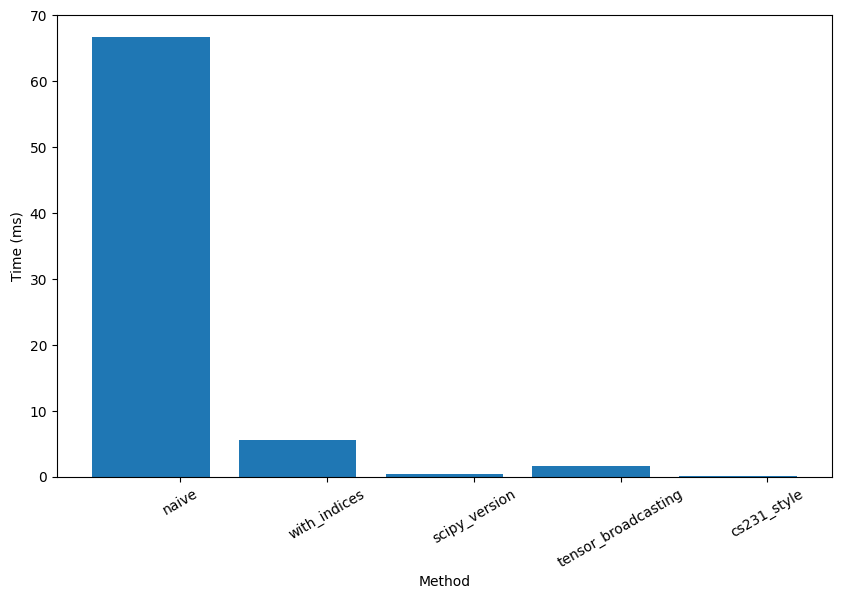

In [24]:
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(methods)), [r.best*1000 for r in timers], log=False)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods))+0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel('Method')
plt.ylabel('Time (ms)')
plt.show()